In [ ]:
# Imports & readDataSubset()
import pandas as pd
import numpy as np
from SMT_Data_Starter_2025 import readDataSubset
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm

# # Load fonts
# font_path = r"C:"
# fm.fontManager.addfont(font_path)
# plt.rcParams['font.family'] = 'Helvetica'

# Just get the subsets out of the way
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

In [ ]:
"""Analysis.ipynb
1. Load datasets & models
2. Calculate baseline Pr(Safe)
    (I.e. Take 1st baseman out of the equation)
    Using catch_probability model
    Using catch_timestamp model
    Using safe_probability model
3. Get "would be" times for effort levels
    (I.e. E[ft_til_1st(_itsx)|effort])
    (Simulate running attempts & contests)
    Using max_acc_cap model
    Using effort model
4. Calculate Pr(Safe) based on "would be" times (median effort)
    Using catch_probability model
    Using safe_probability model
5. Calculate Pr(Safe) based on "would be" times (max effort)
    Using catch_probability model
    Using safe_probability model
X. (Put everything together)
6. Calculate SPA
X. Analysis

"""
pass

In [170]:
"""
Load datasets & models
    1. Load datasets
    2. Load max_acc_cap ensemble (from Running.ipynb)
    3. Load effort model (from Running.ipynb)
    4. Load catch_probability ensemble (from ResultProbs.ipynb)
        (With optimal weights)
    5. Load catch_timestamp ensemble (from ResultProbs.ipynb)
    6. Load safe_probability model (from CatchResults.ipynb)

"""
import pickle
import xgboost as xgb
import catboost as cat
import lightgbm as lgb
from Helpers import Ensemble

## 1. Load datasets
running_hustle = pd.read_csv('../CSV/running_hustle.csv')
ball_plane_run = pd.read_csv('../CSV/ball_plane_run_clean.csv')

## 2. Load max_acc_cap ensemble (from Running.ipynb)
TOP_0 = 1000
max_acc_cap_models = []
for i in range(TOP_0):
    model = cat.CatBoostRegressor()
    model.load_model(f'../Models/max_acc_cap_models/max_acc_cap_model_catboost_{i}')
    max_acc_cap_models.append(model)
max_acc_cap_ensemble = Ensemble([max_acc_cap_models[i] for i in range(TOP_0)])

## 3. Load effort model (coefficients) (from Running.ipynb)
with open('../Models/effort_model_coeffs.pkl', 'rb') as f:
    effort_model_coeffs = pickle.load(f)

## 4. Load catch_probability ensemble (from ResultProbs.ipynb)
TOP_1 = 1
catch_probability_xgb_models = []
catch_probability_cat_models = []
catch_probability_lgb_models = []
for i in range(TOP_1):
    xgb_model = xgb.Booster(model_file=f'../Models/catch_probability_models/catch_probability_model_xgboost_{i}')
    catch_probability_xgb_models.append(xgb_model)
    cat_model = cat.CatBoostClassifier()
    cat_model.load_model(f'../Models/catch_probability_models/catch_probability_model_catboost_{i}')
    catch_probability_cat_models.append(cat_model)
    lgb_model = lgb.Booster(model_file=f'../Models/catch_probability_models/catch_probability_model_lightgbm_{i}') 
    catch_probability_lgb_models.append(lgb_model)
xgb_ensemble = Ensemble([catch_probability_xgb_models[i] for i in range(TOP_1)])
cat_ensemble = Ensemble([catch_probability_cat_models[i] for i in range(TOP_1)])
lgb_ensemble = Ensemble([catch_probability_lgb_models[i] for i in range(TOP_1)])
# Load optimal weights (list)
with open('../Models/catch_probability_optimal_weights.pkl', 'rb') as f:
    optimal_weights = pickle.load(f)

## 5. Load catch_timestamp ensemble (from ResultProbs.ipynb)
TOP_2 = 1000
catch_timestamp_models = []
for i in range(TOP_2):
    model = cat.CatBoostRegressor()
    model.load_model(f'../Models/catch_timestamp_models/catch_timestamp_model_catboost_{i}')
    catch_timestamp_models.append(model)
catch_timestamp_ensemble = Ensemble([catch_timestamp_models[i] for i in range(TOP_2)])

## 5. Load safe_probability model (from CatchResults.ipynb)
with open('../Models/safe_probability_model.pkl', 'rb') as f:
    safe_probability_model = pickle.load(f)

## 5. Load catchoff safe_probability model (from ResultProbs.ipynb)
with open('../Models/safe_probability_catchoff_model.pkl', 'rb') as f:
    safe_probability_catchoff_model = pickle.load(f)

In [171]:
running_hustle.head(2)

,game_str,play_id,batter,hand,contact_ts,startrun_ts,time_to_run,ttr_cutoff,time_lost,timestamp,ft_til_1st_sm,spd_to_1st_sm,acc_to_1st_sm,spd_sm_mapsoft_theta,acc_5to10_95th,effort_percent,hustle_plus
0,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,560749,91.276741,5.896027,18.429326,29.039858,23.519888,80.283552,106.245787
1,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,560799,90.981940,6.817493,19.642164,29.039858,23.519888,80.017342,105.893490


In [172]:
ball_plane_run.head(2)

,game_str,play_id,nth_throw,safe,advanced,thr_ts,acq_ts,arr_ts,closest_itsx_ts,E_itsx_ts,E_ft_til_1st_itsx,ft_til_1st,itsx_catch_ts_delta,plane_orientation_polar,plane_orientation_azimuth,ball_norm_x_plane,ball_dis_plane_origin,proj_ball_z,ball_direction_polar,ball_direction_azimuth
0,y1_d001_CGA_QEA,21,2,True,False,563799,563149.0,564699.0,564599,564599.774035,0.976200,-1.802771,99.225965,135.692773,2.823368,0.333805,6.875793,6.894816,-51.920797,-6.292179
1,y1_d001_CGA_QEA,26,1,False,False,719299,718549.0,719949.0,719849,719849.906467,15.412867,12.778549,99.093533,-150.592275,3.604103,-0.069027,3.840073,4.360963,27.895641,-4.148015


In [29]:
"""
Calculate baseline Pr(Safe)
    (I.e. Take 1st baseman out of the equation)
    Using catch_probability model
    Using catch_timestamp model
    Using safe_probability model
    1. Calculate p(CatchOn|throw)
    2. Calculate E[catch_timing|throw]
    3. Estimate ft_til_1st at catch_timing
    4. Calculate Pr(Safe)
    5. Get time saved by 1st baseman
"""
baseline = ball_plane_run.copy()

## 1. Calculate p(CatchOn|throw)
X = baseline[xgb_ensemble.models[0].feature_names]
y_prob_ensemble = (xgb_ensemble.predict_proba(X)*optimal_weights[0] + 
                   cat_ensemble.predict_proba(X)*optimal_weights[1] + 
                   lgb_ensemble.predict_proba(X)*optimal_weights[2])
baseline['pr_CatchOn']  = [lst[0] for lst in y_prob_ensemble]
baseline['pr_CatchOff'] = [lst[1] for lst in y_prob_ensemble]
baseline['pr_Dropped']  = [lst[2] for lst in y_prob_ensemble]
baseline['pr_Passed']   = [lst[3] for lst in y_prob_ensemble]

## 2. Calculate E[catch_timing|throw]
baseline['E_itsx_catch_ts_delta'] = catch_timestamp_ensemble.predict(X)
baseline['E_catch_ts'] = baseline['E_itsx_ts'] + baseline['E_itsx_catch_ts_delta']

## 3. Estimate ft_til_1st at catch_timing
# Get spd_to_1st_sm at closest timestamp before catch
closest_spd = running_hustle[['game_str','play_id','timestamp','ft_til_1st_sm','spd_to_1st_sm']]
baseline = baseline.merge(closest_spd,how='left',on=['game_str','play_id'])
baseline['ts_diff'] = baseline['timestamp'] - baseline['E_catch_ts']
baseline = baseline[baseline['ts_diff'] <= 0]
baseline = baseline.sort_values(by=['game_str','play_id','timestamp']).drop_duplicates(subset=['game_str','play_id'], keep='last')
# Assume speed stays constant
baseline['E_ft_til_1st_catch'] = (
    baseline['ft_til_1st_sm'] + baseline['spd_to_1st_sm'] * baseline['ts_diff'] / 1000)  # ms to s

## 4. Calculate Pr(Safe)
X = baseline[['E_ft_til_1st_catch']].rename(columns={'E_ft_til_1st_catch':'ft_til_1st'})
baseline['pr_safe_given_CatchOn'] = safe_probability_model.predict_proba(X)[:,-1]
baseline['pr_safe_baseline'] = 1 - baseline['pr_CatchOn'] * (1-baseline['pr_safe_given_CatchOn'])

## 5. Get time saved by 1st baseman
baseline['stretch_by_1st_saved_ms'] = baseline['arr_ts'] - baseline['E_catch_ts']
baseline.loc[baseline['pr_CatchOn'] < 0.1, 'stretch_by_1st_saved_ms'] = np.nan

## X. Organize
baseline = baseline[['game_str','play_id','E_itsx_ts','E_catch_ts','pr_safe_baseline','stretch_by_1st_saved_ms']]
baseline.head(1)

,game_str,play_id,E_itsx_ts,E_catch_ts,pr_safe_baseline,stretch_by_1st_saved_ms
68,y1_d001_CGA_QEA,21,564599.774035,564683.850158,0.99818,15.149842


In [ ]:
"""
Get "would be" times for effort levels
    (I.e. E[ft_til_1st(_itsx)|effort])
    (Simulate running attempts & contests)
    Using max_acc_cap model
    Using effort model
    1. Get initial positions
    2. Get "would be" time
    3. Compute (This takes 10+ hours)
"""
from joblib import Parallel, delayed
from tqdm import tqdm

## 1. Get initial positions
initial = running_hustle[['game_str','play_id','timestamp','startrun_ts','time_lost',
                          'spd_sm_mapsoft_theta','acc_5to10_95th','ft_til_1st_sm','spd_to_1st_sm']].copy()
initial['shouldstartrun_ts'] = running_hustle['startrun_ts'] - running_hustle['time_lost']
initial = initial[initial['shouldstartrun_ts'] == initial['timestamp']]
initial = initial.dropna(subset=['spd_sm_mapsoft_theta','acc_5to10_95th'])

## 2. Get "would be" time
def get_wouldbe_ft_til_1st(row, option: str, effort_level, interval_ms=50):
    spd_to_1st_sm = row['spd_to_1st_sm']
    ft_til_1st_sm = row['ft_til_1st_sm']
    destination_ts = row['E_itsx_ts'] if option=='itsx' else row['E_catch_ts']
    ts = row['timestamp']
    force_perc = min(100, np.polyval(effort_model_coeffs, effort_level) * (1))
    while ts + interval_ms < destination_ts:
        # Get next ft_til_1st
        ft_til_1st_sm -= spd_to_1st_sm*interval_ms/1000
        # Predict acceleration
        X = pd.DataFrame([{'spd_to_1st_sm': spd_to_1st_sm,
                           'spd_sm_mapsoft_theta': row['spd_sm_mapsoft_theta'],
                           'acc_5to10_95th': row['acc_5to10_95th']}])
        max_acc_cap = max_acc_cap_ensemble.predict(X)
        pred_acc = max_acc_cap - row['acc_5to10_95th'] + force_perc*row['acc_5to10_95th']
        # Get next speed using acceleration
        spd_to_1st_sm += pred_acc*interval_ms/1000
        ts += interval_ms
    if ts + interval_ms >= destination_ts:  # Must be true
        shortened_interval = ts + interval_ms - destination_ts
        ft_til_1st_sm -= spd_to_1st_sm*shortened_interval/1000
    return ft_til_1st_sm
# Get E_itsx_ts & E_catch_ts
initial = initial.merge(baseline[['game_str','play_id','E_itsx_ts','E_catch_ts']],
                        how='inner',on=['game_str','play_id'])

## 3. Compute (This takes 10+ hours)
runtypes = {
            # 'wouldbe_ft_til_1st_itsx_ifmax': ('itsx', 1.00),
            # 'wouldbe_ft_til_1st_itsx_ifmed': ('itsx', 0.8385),
            # 'wouldbe_ft_til_1st_itsx_ifmean': ('itsx', 0.7582),
            # 'wouldbe_ft_til_1st_itsx_if95': ('itsx', 0.7582),
            # 'wouldbe_ft_til_1st_catch_ifmax':('catch',1.00),
            # 'wouldbe_ft_til_1st_catch_ifmed':('catch',0.8385),
            # 'wouldbe_ft_til_1st_catch_ifmean':('catch',0.7582),
            # 'wouldbe_ft_til_1st_catch_if95': ('itsx', 0.7582),
            }
for col_name, (opt, eff) in runtypes.items():
    progressbar = tqdm(initial.iterrows(), total=len(initial), desc=col_name)
    initial[col_name] = Parallel(n_jobs=-1)(
        delayed(get_wouldbe_ft_til_1st)(row, option=opt, effort_level=eff)
        for _, row in progressbar)
# Organize
# (The values are listed for some reason)
# initial['wouldbe_ft_til_1st_itsx_ifmax'] = initial['wouldbe_ft_til_1st_itsx_ifmax'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_itsx_ifmed'] = initial['wouldbe_ft_til_1st_itsx_ifmed'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_itsx_ifmean'] = initial['wouldbe_ft_til_1st_itsx_ifmean'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_itsx_if95'] = initial['wouldbe_ft_til_1st_itsx_if95'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_catch_ifmax'] = initial['wouldbe_ft_til_1st_catch_ifmax'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_catch_ifmed'] = initial['wouldbe_ft_til_1st_catch_ifmed'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_catch_ifmean'] = initial['wouldbe_ft_til_1st_catch_ifmean'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_catch_if95'] = initial['wouldbe_ft_til_1st_catch_if95'].apply(lambda x: x[0]).astype(np.float32)

## X. Save
# wouldbe = initial.copy()
# wouldbe.to_csv('../CSV/wouldbe.csv', index=False)   

In [31]:
## X. Load saved file for brevity
wouldbe = pd.read_csv('../CSV/wouldbe.csv')
wouldbe.head(1)

,game_str,play_id,timestamp,startrun_ts,time_lost,spd_sm_mapsoft_theta,acc_5to10_95th,ft_til_1st_sm,spd_to_1st_sm,shouldstartrun_ts,E_itsx_ts,E_catch_ts,wouldbe_ft_til_1st_itsx_ifmax,wouldbe_ft_til_1st_itsx_ifmed,wouldbe_ft_til_1st_catch_ifmax,wouldbe_ft_til_1st_catch_ifmed,wouldbe_ft_til_1st_itsx_ifmean,wouldbe_ft_til_1st_catch_ifmean
0,y1_d001_CGA_QEA,21.0,560749,560749.0,0.0,29.039858,23.519888,91.276741,5.896027,560749.0,564599.774035,564681.403546,-4.404517,2.110627,-4.961859,1.588369,4.927117,4.492168


In [32]:
"""
Calculate Pr(Safe) based on "would be" times (max effort)
    Using catch_probability model
    Using safe_probability model
    1. Calculate p(CatchOn|throw)
    2. Calculate Pr(Safe)
"""
# Load data
wouldbe_max = wouldbe[['game_str','play_id','wouldbe_ft_til_1st_itsx_ifmax','wouldbe_ft_til_1st_catch_ifmax']].copy()
mask = ['game_str','play_id','E_itsx_ts','E_ft_til_1st_itsx'] + xgb_ensemble.models[0].feature_names
wouldbe_max = pd.merge(wouldbe_max, ball_plane_run[mask], how='inner', on=['game_str','play_id'])
wouldbe_max = wouldbe_max.drop(columns=['E_ft_til_1st_itsx'])
wouldbe_max = wouldbe_max.rename(columns={'wouldbe_ft_til_1st_itsx_ifmax':'E_ft_til_1st_itsx',
                                          'wouldbe_ft_til_1st_catch_ifmax':'ft_til_1st'})

## 1. Calculate p(CatchOn|throw)
X = wouldbe_max[xgb_ensemble.models[0].feature_names]
y_prob_ensemble = (xgb_ensemble.predict_proba(X)*optimal_weights[0] + 
                   cat_ensemble.predict_proba(X)*optimal_weights[1] + 
                   lgb_ensemble.predict_proba(X)*optimal_weights[2])
wouldbe_max['pr_CatchOn']  = [lst[0] for lst in y_prob_ensemble]
wouldbe_max['pr_CatchOff'] = [lst[1] for lst in y_prob_ensemble]
wouldbe_max['pr_Dropped']  = [lst[2] for lst in y_prob_ensemble]
wouldbe_max['pr_Passed']   = [lst[3] for lst in y_prob_ensemble]

## 2. Calculate Pr(Safe)
X = wouldbe_max[['ft_til_1st']]
wouldbe_max['pr_safe_given_CatchOn'] = safe_probability_model.predict_proba(X)[:,-1]
wouldbe_max['pr_safe_given_CatchOff'] = safe_probability_catchoff_model.predict_proba(X)[:,-1]
wouldbe_max['pr_safe_wouldbe_max'] = (1 - 
                                      wouldbe_max['pr_CatchOn'] * (1-wouldbe_max['pr_safe_given_CatchOn']) - 
                                      wouldbe_max['pr_CatchOff'] * (1-wouldbe_max['pr_safe_given_CatchOff']))

# X. Organize
wouldbe_max = wouldbe_max.drop(columns=xgb_ensemble.models[0].feature_names)
wouldbe_max = wouldbe_max[['game_str','play_id','pr_safe_wouldbe_max']]
wouldbe_max.head(1)

,game_str,play_id,pr_safe_wouldbe_max
0,y1_d001_CGA_QEA,21.0,0.999985


In [33]:
"""
Calculate Pr(Safe) based on "would be" times (median effort)
    Using catch_probability model
    Using safe_probability model
    1. Calculate p(CatchOn|throw)
    2. Calculate Pr(Safe)
"""
# Load data
wouldbe_med = wouldbe[['game_str','play_id','wouldbe_ft_til_1st_itsx_ifmed','wouldbe_ft_til_1st_catch_ifmed']].copy()
mask = ['game_str','play_id','E_itsx_ts','E_ft_til_1st_itsx'] + xgb_ensemble.models[0].feature_names
wouldbe_med = pd.merge(wouldbe_med, ball_plane_run[mask], how='inner', on=['game_str','play_id'])
wouldbe_med = wouldbe_med.drop(columns=['E_ft_til_1st_itsx'])
wouldbe_med = wouldbe_med.rename(columns={'wouldbe_ft_til_1st_itsx_ifmed':'E_ft_til_1st_itsx',
                                          'wouldbe_ft_til_1st_catch_ifmed':'ft_til_1st'})

## 1. Calculate p(CatchOn|throw)
X = wouldbe_med[xgb_ensemble.models[0].feature_names]
y_prob_ensemble = (xgb_ensemble.predict_proba(X)*optimal_weights[0] + 
                   cat_ensemble.predict_proba(X)*optimal_weights[1] + 
                   lgb_ensemble.predict_proba(X)*optimal_weights[2])
wouldbe_med['pr_CatchOn']  = [lst[0] for lst in y_prob_ensemble]
wouldbe_med['pr_CatchOff'] = [lst[1] for lst in y_prob_ensemble]
wouldbe_med['pr_Dropped']  = [lst[2] for lst in y_prob_ensemble]
wouldbe_med['pr_Passed']   = [lst[3] for lst in y_prob_ensemble]

## 2. Calculate Pr(Safe)
X = wouldbe_med[['ft_til_1st']]
wouldbe_med['pr_safe_given_CatchOn'] = safe_probability_model.predict_proba(X)[:,-1]
wouldbe_med['pr_safe_given_CatchOff'] = safe_probability_catchoff_model.predict_proba(X)[:,-1]
wouldbe_med['pr_safe_wouldbe_med'] = (1 - 
                                      wouldbe_med['pr_CatchOn'] * (1-wouldbe_med['pr_safe_given_CatchOn']) - 
                                      wouldbe_med['pr_CatchOff'] * (1-wouldbe_med['pr_safe_given_CatchOff']))

# X. Organize
wouldbe_med = wouldbe_med.drop(columns=xgb_ensemble.models[0].feature_names)
wouldbe_med = wouldbe_med[['game_str','play_id','pr_safe_wouldbe_med']]
wouldbe_med.head(1)

,game_str,play_id,pr_safe_wouldbe_med
0,y1_d001_CGA_QEA,21.0,0.935293


In [34]:
"""
Calculate Pr(Safe) based on "would be" times (mean effort)
    Using catch_probability model
    Using safe_probability model
    1. Calculate p(CatchOn|throw)
    2. Calculate Pr(Safe)
"""
# Load data
wouldbe_mean = wouldbe[['game_str','play_id','wouldbe_ft_til_1st_itsx_ifmean','wouldbe_ft_til_1st_catch_ifmean']].copy()
mask = ['game_str','play_id','E_itsx_ts','E_ft_til_1st_itsx'] + xgb_ensemble.models[0].feature_names
wouldbe_mean = pd.merge(wouldbe_mean, ball_plane_run[mask], how='inner', on=['game_str','play_id'])
wouldbe_mean = wouldbe_mean.drop(columns=['E_ft_til_1st_itsx'])
wouldbe_mean = wouldbe_mean.rename(columns={'wouldbe_ft_til_1st_itsx_ifmean':'E_ft_til_1st_itsx',
                                          'wouldbe_ft_til_1st_catch_ifmean':'ft_til_1st'})

## 1. Calculate p(CatchOn|throw)
X = wouldbe_mean[xgb_ensemble.models[0].feature_names]
y_prob_ensemble = (xgb_ensemble.predict_proba(X)*optimal_weights[0] + 
                   cat_ensemble.predict_proba(X)*optimal_weights[1] + 
                   lgb_ensemble.predict_proba(X)*optimal_weights[2])
wouldbe_mean['pr_CatchOn']  = [lst[0] for lst in y_prob_ensemble]
wouldbe_mean['pr_CatchOff'] = [lst[1] for lst in y_prob_ensemble]
wouldbe_mean['pr_Dropped']  = [lst[2] for lst in y_prob_ensemble]
wouldbe_mean['pr_Passed']   = [lst[3] for lst in y_prob_ensemble]

## 2. Calculate Pr(Safe)
X = wouldbe_mean[['ft_til_1st']]
wouldbe_mean['pr_safe_given_CatchOn'] = safe_probability_model.predict_proba(X)[:,-1]
wouldbe_mean['pr_safe_given_CatchOff'] = safe_probability_catchoff_model.predict_proba(X)[:,-1]
wouldbe_mean['pr_safe_wouldbe_mean'] = (1 - 
                                      wouldbe_mean['pr_CatchOn'] * (1-wouldbe_mean['pr_safe_given_CatchOn']) - 
                                      wouldbe_mean['pr_CatchOff'] * (1-wouldbe_mean['pr_safe_given_CatchOff']))

# X. Organize
wouldbe_mean = wouldbe_mean.drop(columns=xgb_ensemble.models[0].feature_names)
wouldbe_mean = wouldbe_mean[['game_str','play_id','pr_safe_wouldbe_mean']]
wouldbe_mean.head(1)

,game_str,play_id,pr_safe_wouldbe_mean
0,y1_d001_CGA_QEA,21.0,0.724288


In [38]:
"""
Put everything together
"""
analysis_df = wouldbe[['game_str','play_id','time_lost','spd_sm_mapsoft_theta','acc_5to10_95th',
                'wouldbe_ft_til_1st_itsx_ifmax','wouldbe_ft_til_1st_itsx_ifmed',
                'wouldbe_ft_til_1st_catch_ifmax','wouldbe_ft_til_1st_catch_ifmed'
                ]].copy()
# Merge (nth_throw, safe, advanced)
analysis_df = pd.merge(ball_plane_run[['game_str','play_id','nth_throw','safe','advanced']], 
                analysis_df, how='inner', on=['game_str','play_id'])
# Merge wouldbe_med
analysis_df = pd.merge(wouldbe_med, analysis_df, how='inner', on=['game_str','play_id'])
# Merge wouldbe_max
analysis_df = pd.merge(wouldbe_max, analysis_df, how='inner', on=['game_str','play_id'])
# Merge wouldbe_mean
analysis_df = pd.merge(wouldbe_mean, analysis_df, how='inner', on=['game_str','play_id'])
# Merge baseline
analysis_df = pd.merge(baseline, analysis_df, how='inner', on=['game_str','play_id'])
analysis_df = analysis_df.drop(columns=['E_itsx_ts','E_catch_ts'])
# Merge (batter, hand, effort_percent, hustle_plus)
runs = (running_hustle.groupby(['game_str','play_id','batter','hand'])
                      .agg(mean_hustle_plus=('hustle_plus','mean'),
                           mean_effort=('effort_percent','mean'))
                      .reset_index())
analysis_df = pd.merge(runs, analysis_df, how='inner', on=['game_str','play_id'])

analysis_df.head(1)

## X. Save
analysis = analysis_df.copy()
analysis.to_csv('../CSV/analysis.csv', index=False)   

In [39]:
"""
Calculate SPA
"""
analysis_df['safe_prob_added_med'] = analysis_df['pr_safe_baseline'] - analysis_df['pr_safe_wouldbe_med']
# analysis_df['safe_prob_added_mean'] = analysis_df['pr_safe_baseline'] - analysis_df['pr_safe_wouldbe_mean']
analysis_df.head(1)

,game_str,play_id,batter,hand,mean_hustle_plus,mean_effort,pr_safe_baseline,stretch_by_1st_saved_ms,pr_safe_wouldbe_mean,pr_safe_wouldbe_max,...,safe,advanced,time_lost,spd_sm_mapsoft_theta,acc_5to10_95th,wouldbe_ft_til_1st_itsx_ifmax,wouldbe_ft_til_1st_itsx_ifmed,wouldbe_ft_til_1st_catch_ifmax,wouldbe_ft_til_1st_catch_ifmed,safe_prob_added_med
0,y1_d001_CGA_QEA,21.0,CGA-1824,R,136.484299,97.409049,0.99818,15.149842,0.724288,0.999985,...,True,False,0.0,29.039858,23.519888,-4.404517,2.110627,-4.961859,1.588369,0.062888


C:\Users\mla21\AppData\Local\Temp\ipykernel_1700\4290150354.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_play['mean_effort'] = (single_play['mean_effort']).round()
C:\Users\mla21\AppData\Local\Temp\ipykernel_1700\4290150354.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doubletriple_play['mean_effort'] = (doubletriple_play['mean_effort'] / 1).round() * 1


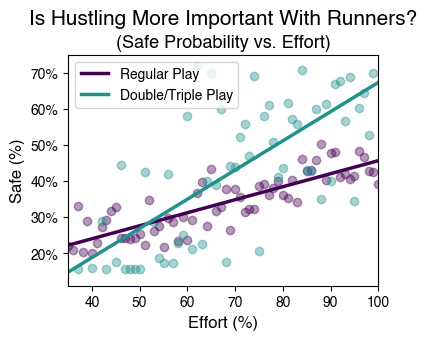

In [326]:
"""
Hustling for Double/Triple Plays
"""
from scipy.stats import linregress
from matplotlib.ticker import PercentFormatter

temp = analysis_df.copy()
temp = temp[(temp['mean_effort'] >= 35)]
# Aggregate at each effort level
single_play = temp[temp['nth_throw']==1]
single_play['mean_effort'] = (single_play['mean_effort']).round()
doubletriple_play = temp[temp['nth_throw']>1]
doubletriple_play['mean_effort'] = (doubletriple_play['mean_effort'] / 1).round() * 1
sp_prsafes = single_play.groupby(['mean_effort']).agg(pr_safe = ('pr_safe_baseline','mean')).reset_index()
dtp_prsafes = doubletriple_play.groupby(['mean_effort']).agg(pr_safe = ('pr_safe_baseline','mean')).reset_index()
# Fit
slope_sp, intercept_sp, r_sp, p_sp, se_sp = linregress(sp_prsafes['mean_effort'],sp_prsafes['pr_safe'])
slope_dtp, intercept_dtp, r_dtp, p_dtp, se_dtp = linregress(dtp_prsafes['mean_effort'],dtp_prsafes['pr_safe'])
line_x = np.linspace(20,100,160)
line_y_sp = slope_sp*line_x + intercept_sp
line_y_dtp = slope_dtp*line_x + intercept_dtp 
# Prepare
plt.figure(figsize=(4,3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]
# Plot
plt.plot(line_x, line_y_sp, color=colors[0], lw=2.5, label='Regular Play')
plt.plot(line_x, line_y_dtp, color=colors[1], lw=2.5, label='Double/Triple Play')
plt.scatter(sp_prsafes['mean_effort'],sp_prsafes['pr_safe'], color=colors[0], alpha=0.4)
plt.scatter(dtp_prsafes['mean_effort'],dtp_prsafes['pr_safe'], color=colors[1], alpha=0.4)
plt.xlabel('Effort (%)', fontsize=12)
plt.ylabel('Safe (%)', fontsize=12)
plt.xlim(35,100)
plt.ylim(0.11,0.75)
plt.title('Is Hustling More Important With Runners?', fontsize=15, pad=22)
plt.text(x=45,y=0.77,s='(Safe Probability vs. Effort)', fontsize=13)
plt.legend(fontsize=10, loc='upper left')
plt.show()


C:\Users\mla21\AppData\Local\Temp\ipykernel_1700\1101414310.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nothhb['mean_effort'] = (nothhb['mean_effort']/2).round(0)*2


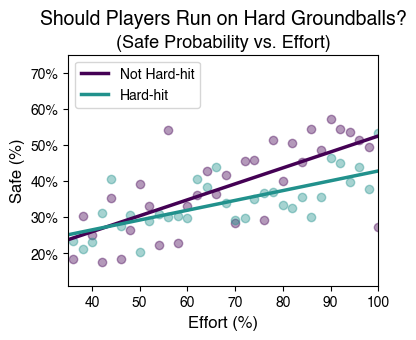

In [203]:
"""
Hustling on Hard-Hit Balls
"""
contact_ts = running_hustle[['game_str','play_id','contact_ts']]
acq_ts = ball_plane_run[['game_str','play_id','acq_ts']]
contact_acq_ts = pd.merge(contact_ts,acq_ts,how='inner',on=['game_str','play_id'])
contact_acq_ts['contact_acq_ts_diff'] = contact_acq_ts['acq_ts'] - contact_acq_ts['contact_ts']

# Only look at regular plays
temp = analysis_df[analysis_df['nth_throw']==1].copy()
temp = temp[(temp['mean_effort'] >= 35)]
hhb = temp.merge(contact_acq_ts,how='inner',on=['game_str','play_id'])
# Aggregate at each effort level
nothhb = hhb[hhb['contact_acq_ts_diff']>2250]
nothhb['mean_effort'] = (nothhb['mean_effort']/2).round(0)*2
hhb = hhb[hhb['contact_acq_ts_diff']<1750]
hhb['mean_effort'] = (hhb['mean_effort']/2).round(0)*2
nothhb_prsafes = nothhb.groupby(['mean_effort']).agg(pr_safe = ('pr_safe_baseline','mean')).reset_index()
hhb_prsafes = hhb.groupby(['mean_effort']).agg(pr_safe = ('pr_safe_baseline','mean')).reset_index()
# Fit
slope_sp, intercept_sp, r_sp, p_sp, se_sp = linregress(nothhb_prsafes['mean_effort'],nothhb_prsafes['pr_safe'])
slope_dtp, intercept_dtp, r_dtp, p_dtp, se_dtp = linregress(hhb_prsafes['mean_effort'],hhb_prsafes['pr_safe'])
line_x = np.linspace(20,100,160)
line_y_sp = slope_sp*line_x + intercept_sp
line_y_dtp = slope_dtp*line_x + intercept_dtp 
# Prepare
plt.figure(figsize=(4,3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]
# Plot
plt.plot(line_x, line_y_sp, color=colors[0], lw=2.5, label='Not Hard-hit')
plt.plot(line_x, line_y_dtp, color=colors[1], lw=2.5, label='Hard-hit')
plt.scatter(nothhb_prsafes['mean_effort'],nothhb_prsafes['pr_safe'], color=colors[0], alpha=0.4)
plt.scatter(hhb_prsafes['mean_effort'],hhb_prsafes['pr_safe'], color=colors[1], alpha=0.4)
plt.xlabel('Effort (%)', fontsize=12)
plt.ylabel('Safe (%)', fontsize=12)
plt.xlim(35,100)
plt.ylim(0.11,0.75)
plt.title('Should Players Run on Hard Groundballs?', fontsize=14, pad=22)
plt.text(x=45,y=0.77,s='(Safe Probability vs. Effort)', fontsize=13)
plt.legend(fontsize=10, loc='upper left')
plt.show()

In [216]:
analysis_df.columns

Index(['game_str', 'play_id', 'batter', 'hand', 'mean_hustle_plus',
       'mean_effort', 'pr_safe_baseline', 'stretch_by_1st_saved_ms',
       'pr_safe_wouldbe_mean', 'pr_safe_wouldbe_max', 'pr_safe_wouldbe_med',
       'nth_throw', 'safe', 'advanced', 'time_lost', 'spd_sm_mapsoft_theta',
       'acc_5to10_95th', 'wouldbe_ft_til_1st_itsx_ifmax',
       'wouldbe_ft_til_1st_itsx_ifmed', 'wouldbe_ft_til_1st_catch_ifmax',
       'wouldbe_ft_til_1st_catch_ifmed', 'safe_prob_added_med'],
      dtype='object')

In [365]:
effort_safe

,mean_effort,safe_plus
31,35.0,-1.144421
32,36.0,-1.168960
33,37.0,-1.061764
34,38.0,-1.174401
35,39.0,-1.088829
...,...,...
92,96.0,-0.870030
93,97.0,-0.892305
94,98.0,-0.931356
95,99.0,-0.887954


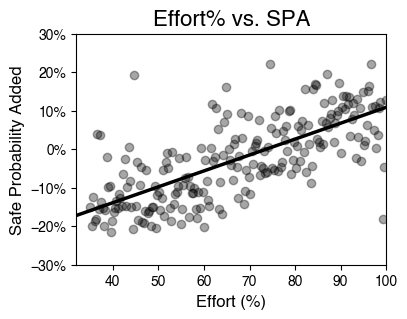

In [377]:
"""
Hustling for Double/Triple Plays
"""
from scipy.stats import linregress
from matplotlib.ticker import PercentFormatter


effort = analysis_df.copy()
# Aggregate at each effort level
effort['mean_effort'] = (effort['mean_effort']/3).round(1)*3
effort['safe_plus'] = effort['pr_safe_baseline'] - effort['pr_safe_baseline'].mean() 
effort_safe = effort.groupby('mean_effort').agg(safe_plus = ('safe_plus','mean')).reset_index()
effort_safe = effort_safe[effort_safe['mean_effort'] >= 35]
# Fit
slope, intercept, r, p, se = linregress(effort_safe['mean_effort'],effort_safe['safe_plus'])
line_x = np.linspace(20,100,160)
line_y = slope*line_x + intercept
# Prepare
plt.figure(figsize=(4,3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]
# Plot
plt.plot(line_x, line_y, color='black', lw=2.5, label='Regular Play')
plt.scatter(effort_safe['mean_effort'],effort_safe['safe_plus'], color='black', alpha=0.35)
plt.xlabel('Effort (%)', fontsize=12)
plt.ylabel('Safe Probability Added', fontsize=12)
plt.xlim(32,100)
plt.ylim(-0.3,.3)
plt.title('Effort% vs. SPA', fontsize=16)
plt.show()

,batter,safe_prob_added,contests,spa_per_contest
549,RZQ-0347,2.728385,73,0.037375
544,RZQ-0318,2.379816,15,0.158654
537,RZQ-0258,1.903825,18,0.105768
137,FBP-2170,1.774482,7,0.253497
98,DYE-0122,1.655992,24,0.069000
...,...,...,...,...
713,YJD-0020,-2.195244,9,-0.243916
539,RZQ-0275,-2.719744,23,-0.118250
751,YJD-0366,-3.253068,18,-0.180726
542,RZQ-0310,-4.136847,45,-0.091930


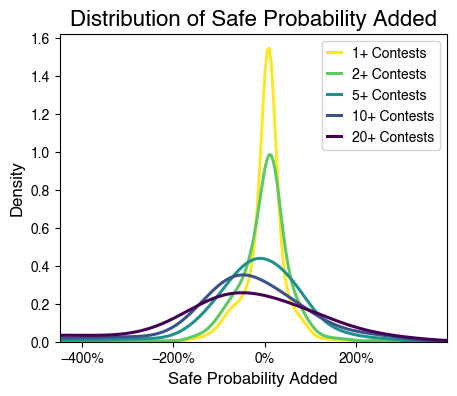

In [314]:
"""
Distribution of Safe Probability Added
"""
spa = analysis_df.groupby('batter').agg(safe_prob_added = ('safe_prob_added_med','sum'),
                                         contests = ('safe_prob_added_med','size')).reset_index()
spa['spa_per_contest'] = spa['safe_prob_added'] / spa['contests']
spa_1 = spa[spa['contests'] >= 1]
spa_2 = spa[spa['contests'] >= 2]
spa_5 = spa[spa['contests'] >= 5]
spa_10 = spa[spa['contests'] >= 10]
spa_20 = spa[spa['contests'] >= 20]
# Plot
plt.figure(figsize=(5,4), dpi=100)
cmap = plt.get_cmap(name='viridis')
colors = [cmap(i) for i in np.linspace(0,1,5)]
sns.kdeplot(spa_1['safe_prob_added'], color=colors[4], label='1+ Contests', lw=2.2)
sns.kdeplot(spa_2['safe_prob_added'], color=colors[3], label='2+ Contests', lw=2.2)
sns.kdeplot(spa_5['safe_prob_added'], color=colors[2], label='5+ Contests', lw=2.2)
sns.kdeplot(spa_10['safe_prob_added'], color=colors[1], label='10+ Contests', lw=2.2)
sns.kdeplot(spa_20['safe_prob_added'], color=colors[0], label='20+ Contests', lw=2.2)
plt.legend(loc='upper right', handlelength=1)
plt.xlim(-4.5,4)
plt.xticks(np.arange(-4,4,2))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.title('Distribution of Safe Probability Added', fontsize=16)
plt.xlabel('Safe Probability Added', fontsize=12)
plt.ylabel('Density', fontsize=12)

spa.sort_values('safe_prob_added',ascending=False)

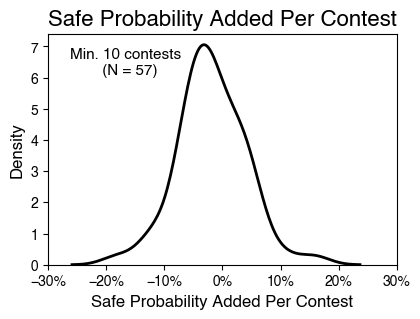

In [ ]:
## X. Extra Visualization
plt.figure(figsize=(4.5,3))
sns.kdeplot(spa_10['spa_per_contest'], color='black', label='10+ Contests', lw=2)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.xlim(-0.3,0.3)
plt.ylabel('Count',fontsize=11)
plt.xlabel('Hustle+',fontsize=11)
plt.title('Hustle+ Distribution', fontsize=16)
plt.title('Safe Probability Added Per Contest', fontsize=16)
plt.xlabel('Safe Probability Added Per Contest', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.axvline(x=0.05, color='black', alpha = 0.7, )
plt.text(0.23,0.94,f"Min. 10 contests \n (N = {len(spa_10)})", fontsize=11, 
         va='top', ha='center', transform=plt.gca().transAxes);
# spa_5.sort_values('safe_prob_added',ascending=False)

In [325]:
contests_per_game = analysis_df.groupby('game_str').agg(count=('game_str','count')).reset_index()['count']
contests_per_game.mean()

11.211764705882352